<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of excel data and timeseries prediction

Das Ziel dieses Beispieles ist es die Arbeit mit Zeitreihen aus Excel Files zu zeigen und darauf ein Vorhersagemodell für Zeitreihen zu entwickeln. Der Datensatz beschreibt die Entwicklung von Flugpassagierzahlen einer Airline in der fernen Vergangenheit. Die Daten sind aber typisch für Daten wie sie KMUs (z.B. Verkaufszahlen) zu finden sind. 


Der Code für das Beispiel wurde aus [1] adaptiert. Weitergehende Informationen sind zum Beispiel in [2] zu finden. 

- [1] [https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- [2] [https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa](https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa)


Zitierung Datensatz:
```
Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.
```


# Import der Module

In [788]:
#
# Import der Module
#
import os
import openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (16,9)


In [789]:
#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [790]:
#
# Für GPU Support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.0.0


# Konstanten

In [791]:
#
# Konstanten für Dateien
#
excelData = 'data/airline_passengers.xlsx'

In [792]:
data = pd.ExcelFile(excelData)
print(data.sheet_names)

['Tabellenblatt1']


In [793]:
#
# Auslesen eines Tabellenblattes
#
df = data.parse('Tabellenblatt1')
df.info
df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,Month,Passengers
3,NaN,1949-01-01 00:00:00,112
4,NaN,1949-02-01 00:00:00,118
5,NaN,1949-03-01 00:00:00,132
6,NaN,1949-04-01 00:00:00,129
7,NaN,1949-05-01 00:00:00,121
8,NaN,1949-06-01 00:00:00,135
9,NaN,1949-07-01 00:00:00,148


In [794]:
df.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
142,NaN,1960-08-01 00:00:00,606
143,NaN,1960-09-01 00:00:00,508
144,NaN,1960-10-01 00:00:00,461
145,NaN,1960-11-01 00:00:00,390
146,NaN,1960-12-01 00:00:00,432


# Ausschneiden von Daten in pandas dataframes

Ein sehr gutes Tutorial dazu kann hier gefunden werden: [https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)

In [795]:
#
# Ausschneiden der benötigten Daten
#
df_cut = df.iloc[3:146,1:3]

In [796]:
df_cut.head()

,Unnamed: 1,Unnamed: 2
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121


In [797]:
df_cut.columns = ['month','passengers']

In [798]:
df_cut.head()

,month,passengers
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121


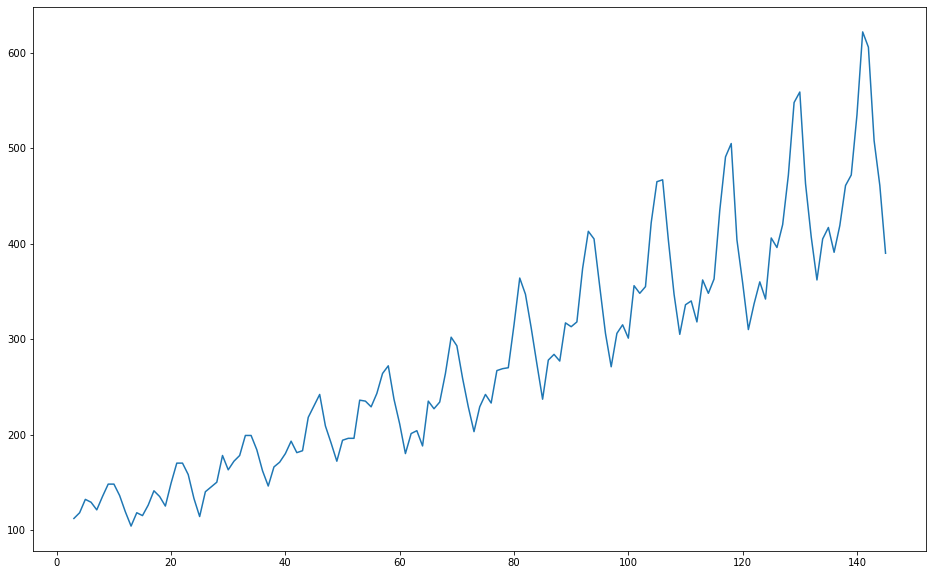

In [799]:
df_cut['passengers'].plot()

# Konventionelle Arbeit mit solchen Zeitreihen

Es gibt eine Reihe von älteren Methoden um mit solchen Zeitreihen umzugehen und auch gute Ergebnisse bei der Vorhersage zu erreichen. Beispiele dazu sind hier zu finden:

- https://machinelearningmastery.com/time-series-trends-in-python/
- https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa


Die wesentliche Leistung dieser Verfahren ist die Berechnung und Verwendung von Parameters wie **Trend** und **Saisonalität**. Wir hoffen, dass unsere Modelle damit umgehen können, ohne dass wir uns explizit darum kümmern müssen.


In [800]:
x_data = df_cut['passengers'].values
x_data = x_data.astype('float32')
x_data = np.reshape(x_data,(-1,1))
print(x_data)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


In [801]:
#
# Normalize the dataset
#
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaler.fit(x_data)

MinMaxScaler(copy=True, feature_range=(0.0, 1.0))

In [802]:
print(scaler.data_max_)

[622.]


In [803]:
x_data = scaler.transform(x_data)
print(x_data)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

In [804]:
# split into train and test sets
train_size = int(len(x_data) * 0.80)
test_size = len(x_data) - train_size
train, test = x_data[0:train_size,:], x_data[train_size:len(x_data),:]
print(len(train), len(test))

114 29


# Erzeugen eines Trainingsdatensatzes mit Hilfe von sliding windows

Sliding windows werden aus einer Zeitreihe erzeugt, indem ein Fenster über die gesamte Zeitreihe gezogen wird und dabei jeweils die Daten im Fenster kopiert werden. Mehr Details dazu hier [https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe](https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe).

In [805]:
#
# Transformation einer Zeitreihe in sliding windows mit einem label (y)
#
def createSlidingWindowsWithLabel(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[ i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [806]:
#
# Anwenden der sliding window Funktion
#
look_back = 1
trainX, trainY = createSlidingWindowsWithLabel(train, look_back)
testX, testY = createSlidingWindowsWithLabel(test, look_back)

In [807]:
# 
# reshape input to be [samples, time steps, features]
#
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [808]:
#
# create and fit the LSTM network
#
def createLSTMModel():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [809]:
lstm_model = createLSTMModel()

In [810]:
lstm_model.fit(trainX, trainY, epochs=40, batch_size=1, verbose=1)

Epoch 1/40
112/112 [==============================] - 2s 18ms/step - loss: 0.0642
Epoch 2/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0309
Epoch 3/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 4/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 5/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 6/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 7/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 8/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 9/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 10/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 11/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 12/40
112/112 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 13/40
112/112 [===

In [811]:
#
# Schätzung der Werte für train und test Daten
#
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

In [812]:
#
# Rücktransformation der Schätzungen (scaler)
#
trainPredict = scaler.inverse_transform(trainPredict)
trainYi = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYi = scaler.inverse_transform([testY])

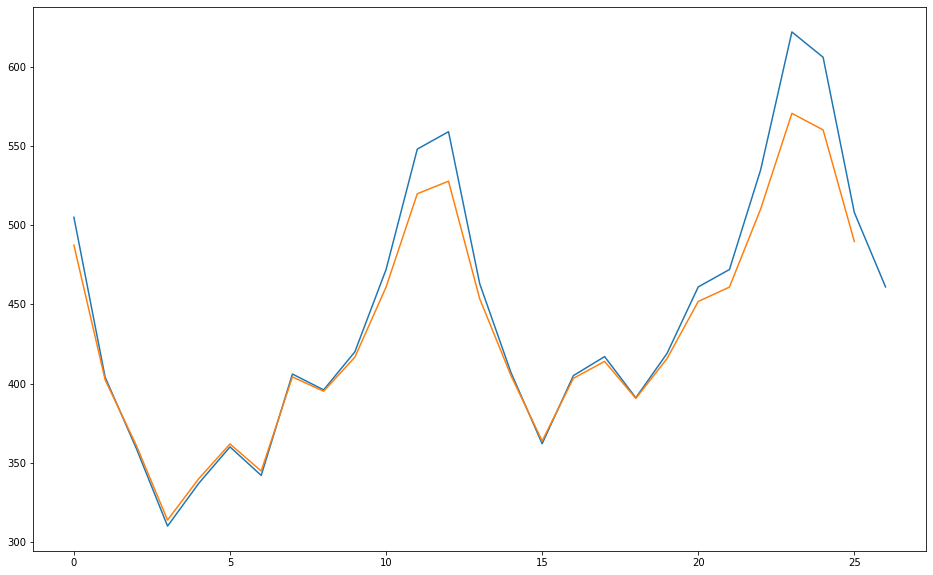

In [813]:
#
# Anzeige der geschätzten neuen Werte
#
plt.plot(testYi[0,0:])
plt.plot(testPredict[1:,0])
plt.show()

In [814]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYi[0,0:-1], trainPredict[1:,0]))
print('train loss: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYi[0,0:-1], testPredict[1:,0]))
print('test loss: %.3f RMSE' % (testScore))

train loss: 6.332 RMSE
test loss: 17.852 RMSE


In [815]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(x_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(trainPredict)+0, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(x_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(x_data)-2, :] = testPredict

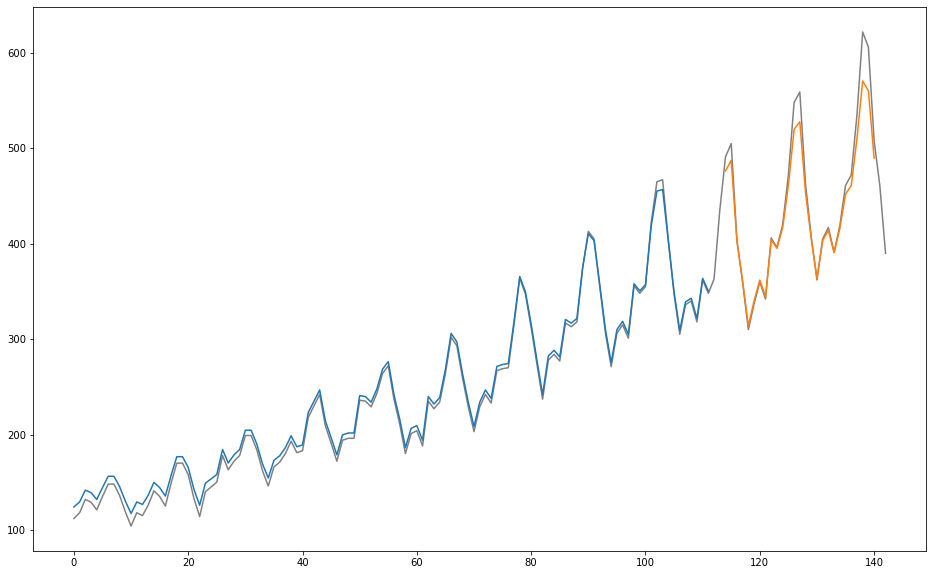

In [816]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(x_data), color='grey')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Verbesserung durch Verwendung von Zusatzinformation in den Daten

**Idee**: In dem Datensatz stecken mehr Informationen als wir bisher verwendet haben. Zum Beispiel das Monat eines Jahres sowie das Jahr. Wir können den Datensatz um diese Information anreichern um dem Modell mehr Informationen zu geben. Diese zusätzlich Information können wir aus dem Datumsfeature in den Originaldaten ableiten.

In [817]:
df_cut.head()

,month,passengers
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121


In [818]:
df_cut['date'] = pd.to_datetime(df_cut['month'], infer_datetime_format=True )

In [819]:
df_cut.head()

,month,passengers,date
3,1949-01-01 00:00:00,112,1949-01-01
4,1949-02-01 00:00:00,118,1949-02-01
5,1949-03-01 00:00:00,132,1949-03-01
6,1949-04-01 00:00:00,129,1949-04-01
7,1949-05-01 00:00:00,121,1949-05-01


In [820]:
df_cut['year'] = pd.DatetimeIndex(df_cut['date']).year
df_cut['month'] = pd.DatetimeIndex(df_cut['date']).month

In [821]:
df_cut.head()

,month,passengers,date,year
3,1,112,1949-01-01,1949
4,2,118,1949-02-01,1949
5,3,132,1949-03-01,1949
6,4,129,1949-04-01,1949
7,5,121,1949-05-01,1949


In [822]:
x_data_raw = df_cut.loc[:, ['month', 'passengers','year']].values
print(x_data_raw)

[[1 112 1949]
 [2 118 1949]
 [3 132 1949]
 [4 129 1949]
 [5 121 1949]
 [6 135 1949]
 [7 148 1949]
 [8 148 1949]
 [9 136 1949]
 [10 119 1949]
 [11 104 1949]
 [12 118 1949]
 [1 115 1950]
 [2 126 1950]
 [3 141 1950]
 [4 135 1950]
 [5 125 1950]
 [6 149 1950]
 [7 170 1950]
 [8 170 1950]
 [9 158 1950]
 [10 133 1950]
 [11 114 1950]
 [12 140 1950]
 [1 145 1951]
 [2 150 1951]
 [3 178 1951]
 [4 163 1951]
 [5 172 1951]
 [6 178 1951]
 [7 199 1951]
 [8 199 1951]
 [9 184 1951]
 [10 162 1951]
 [11 146 1951]
 [12 166 1951]
 [1 171 1952]
 [2 180 1952]
 [3 193 1952]
 [4 181 1952]
 [5 183 1952]
 [6 218 1952]
 [7 230 1952]
 [8 242 1952]
 [9 209 1952]
 [10 191 1952]
 [11 172 1952]
 [12 194 1952]
 [1 196 1953]
 [2 196 1953]
 [3 236 1953]
 [4 235 1953]
 [5 229 1953]
 [6 243 1953]
 [7 264 1953]
 [8 272 1953]
 [9 237 1953]
 [10 211 1953]
 [11 180 1953]
 [12 201 1953]
 [1 204 1954]
 [2 188 1954]
 [3 235 1954]
 [4 227 1954]
 [5 234 1954]
 [6 264 1954]
 [7 302 1954]
 [8 293 1954]
 [9 259 1954]
 [10 229 1954]
 [11

In [823]:
x_data = x_data_raw.astype('float32')

In [824]:
x_data = np.reshape(x_data,(-1,3))

In [825]:
print(x_data)

[[1.000e+00 1.120e+02 1.949e+03]
 [2.000e+00 1.180e+02 1.949e+03]
 [3.000e+00 1.320e+02 1.949e+03]
 [4.000e+00 1.290e+02 1.949e+03]
 [5.000e+00 1.210e+02 1.949e+03]
 [6.000e+00 1.350e+02 1.949e+03]
 [7.000e+00 1.480e+02 1.949e+03]
 [8.000e+00 1.480e+02 1.949e+03]
 [9.000e+00 1.360e+02 1.949e+03]
 [1.000e+01 1.190e+02 1.949e+03]
 [1.100e+01 1.040e+02 1.949e+03]
 [1.200e+01 1.180e+02 1.949e+03]
 [1.000e+00 1.150e+02 1.950e+03]
 [2.000e+00 1.260e+02 1.950e+03]
 [3.000e+00 1.410e+02 1.950e+03]
 [4.000e+00 1.350e+02 1.950e+03]
 [5.000e+00 1.250e+02 1.950e+03]
 [6.000e+00 1.490e+02 1.950e+03]
 [7.000e+00 1.700e+02 1.950e+03]
 [8.000e+00 1.700e+02 1.950e+03]
 [9.000e+00 1.580e+02 1.950e+03]
 [1.000e+01 1.330e+02 1.950e+03]
 [1.100e+01 1.140e+02 1.950e+03]
 [1.200e+01 1.400e+02 1.950e+03]
 [1.000e+00 1.450e+02 1.951e+03]
 [2.000e+00 1.500e+02 1.951e+03]
 [3.000e+00 1.780e+02 1.951e+03]
 [4.000e+00 1.630e+02 1.951e+03]
 [5.000e+00 1.720e+02 1.951e+03]
 [6.000e+00 1.780e+02 1.951e+03]
 [7.000e+0

In [826]:
#
# Normalize the dataset
#
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaler.fit(x_data)

MinMaxScaler(copy=True, feature_range=(0.0, 1.0))

In [827]:
x_data_scaled = scaler.transform(x_data)
print(x_data_scaled)

[[0.         0.01544401 0.        ]
 [0.09090909 0.02702703 0.        ]
 [0.18181819 0.05405405 0.        ]
 [0.27272728 0.04826255 0.        ]
 [0.36363637 0.03281853 0.        ]
 [0.45454547 0.05984557 0.        ]
 [0.5454545  0.08494207 0.        ]
 [0.6363636  0.08494207 0.        ]
 [0.72727275 0.06177607 0.        ]
 [0.8181819  0.02895753 0.        ]
 [0.9090909  0.         0.        ]
 [1.         0.02702703 0.        ]
 [0.         0.02123553 0.09091187]
 [0.09090909 0.04247104 0.09091187]
 [0.18181819 0.07142857 0.09091187]
 [0.27272728 0.05984557 0.09091187]
 [0.36363637 0.04054055 0.09091187]
 [0.45454547 0.08687258 0.09091187]
 [0.5454545  0.12741312 0.09091187]
 [0.6363636  0.12741312 0.09091187]
 [0.72727275 0.10424709 0.09091187]
 [0.8181819  0.05598456 0.09091187]
 [0.9090909  0.01930502 0.09091187]
 [1.         0.06949806 0.09091187]
 [0.         0.07915059 0.18182373]
 [0.09090909 0.08880308 0.18182373]
 [0.18181819 0.14285713 0.18182373]
 [0.27272728 0.11389962 0.18

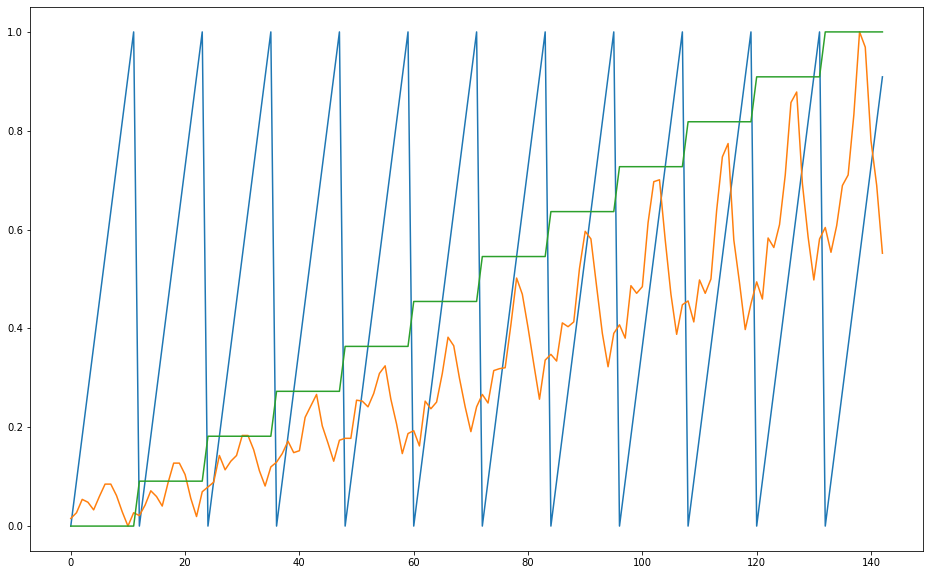

In [828]:
plt.plot(x_data_scaled)

In [829]:
#
# Transformation einer multivariaten Zeitreihe in sliding windows mit einem label (y)
#
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('x%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


In [830]:
#
# Erzeugen der Windows für Vorhersage
#
windowSize = 12
x_data_windowed = series_to_supervised(x_data_scaled, windowSize, 1)
print(x_data_windowed.head())

    x1(t-12)  x2(t-12)  x3(t-12)  x1(t-11)  x2(t-11)  x3(t-11)  x1(t-10)  \
12  0.000000  0.015444       0.0  0.090909  0.027027       0.0  0.181818   
13  0.090909  0.027027       0.0  0.181818  0.054054       0.0  0.272727   
14  0.181818  0.054054       0.0  0.272727  0.048263       0.0  0.363636   
15  0.272727  0.048263       0.0  0.363636  0.032819       0.0  0.454545   
16  0.363636  0.032819       0.0  0.454545  0.059846       0.0  0.545455   

    x2(t-10)  x3(t-10)   x1(t-9)  ...   x3(t-3)   x1(t-2)   x2(t-2)   x3(t-2)  \
12  0.054054       0.0  0.272727  ...  0.000000  0.909091  0.000000  0.000000   
13  0.048263       0.0  0.363636  ...  0.000000  1.000000  0.027027  0.000000   
14  0.032819       0.0  0.454545  ...  0.000000  0.000000  0.021236  0.090912   
15  0.059846       0.0  0.545455  ...  0.090912  0.090909  0.042471  0.090912   
16  0.084942       0.0  0.636364  ...  0.090912  0.181818  0.071429  0.090912   

     x1(t-1)   x2(t-1)   x3(t-1)     y1(t)     y2(t)    

In [831]:
#
# Löschen der Labels, die nicht geschätzt werden sollen (month, year)
#

x_data_windowed.drop(x_data_windowed.columns[[windowSize*3,(windowSize*3)+2]], axis=1, inplace=True)
print(x_data_windowed.head())

    x1(t-12)  x2(t-12)  x3(t-12)  x1(t-11)  x2(t-11)  x3(t-11)  x1(t-10)  \
12  0.000000  0.015444       0.0  0.090909  0.027027       0.0  0.181818   
13  0.090909  0.027027       0.0  0.181818  0.054054       0.0  0.272727   
14  0.181818  0.054054       0.0  0.272727  0.048263       0.0  0.363636   
15  0.272727  0.048263       0.0  0.363636  0.032819       0.0  0.454545   
16  0.363636  0.032819       0.0  0.454545  0.059846       0.0  0.545455   

    x2(t-10)  x3(t-10)   x1(t-9)  ...   x1(t-3)   x2(t-3)   x3(t-3)   x1(t-2)  \
12  0.054054       0.0  0.272727  ...  0.818182  0.028958  0.000000  0.909091   
13  0.048263       0.0  0.363636  ...  0.909091  0.000000  0.000000  1.000000   
14  0.032819       0.0  0.454545  ...  1.000000  0.027027  0.000000  0.000000   
15  0.059846       0.0  0.545455  ...  0.000000  0.021236  0.090912  0.090909   
16  0.084942       0.0  0.636364  ...  0.090909  0.042471  0.090912  0.181818   

     x2(t-2)   x3(t-2)   x1(t-1)   x2(t-1)   x3(t-1)    

In [832]:
#x_data_windowed.plot()

In [833]:
# split into train and test sets
x_data = x_data_windowed.values
train_size = int(len(x_data) * 0.70)
test_size = len(x_data) - train_size
train, test = x_data[0:train_size,:], x_data[train_size:len(x_data),:]
print(train.shape, test.shape)

(91, 37) (40, 37)


In [834]:
#
# Trennen in features und labels
#
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [835]:
#
# Form anpassen für Modell
#
train_X_r = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_r = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X_r.shape, train_y.shape, test_X_r.shape, test_y.shape)

(91, 1, 36) (91,) (40, 1, 36) (40,)


In [936]:
#
# create and fit the LSTM network
#
def createMVLSTMModel():
    model = Sequential()
    model.add(LSTM(100, dropout=0.1, input_shape=(train_X_r.shape[1], train_X_r.shape[2])))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [937]:
model = createMVLSTMModel()
history = model.fit(train_X_r, train_y, epochs=300, batch_size=24, validation_data=(test_X_r, test_y), verbose=1, shuffle=False)    

Train on 91 samples, validate on 40 samples
Epoch 1/300
91/91 [==============================] - 2s 23ms/step - loss: 0.0516 - val_loss: 0.1809
Epoch 2/300
91/91 [==============================] - 0s 447us/step - loss: 0.0110 - val_loss: 0.0506
Epoch 3/300
91/91 [==============================] - 0s 419us/step - loss: 0.0127 - val_loss: 0.0198
Epoch 4/300
91/91 [==============================] - 0s 417us/step - loss: 0.0198 - val_loss: 0.0170
Epoch 5/300
91/91 [==============================] - 0s 437us/step - loss: 0.0155 - val_loss: 0.0224
Epoch 6/300
91/91 [==============================] - 0s 414us/step - loss: 0.0081 - val_loss: 0.0358
Epoch 7/300
91/91 [==============================] - 0s 641us/step - loss: 0.0078 - val_loss: 0.0411
Epoch 8/300
91/91 [==============================] - 0s 419us/step - loss: 0.0052 - val_loss: 0.0307
Epoch 9/300
91/91 [==============================] - 0s 412us/step - loss: 0.0030 - val_loss: 0.0171
Epoch 10/300
91/91 [============================

Epoch 81/300
91/91 [==============================] - 0s 408us/step - loss: 0.0016 - val_loss: 0.0029
Epoch 82/300
91/91 [==============================] - 0s 402us/step - loss: 0.0012 - val_loss: 0.0024
Epoch 83/300
91/91 [==============================] - 0s 414us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 84/300
91/91 [==============================] - 0s 594us/step - loss: 0.0012 - val_loss: 0.0029
Epoch 85/300
91/91 [==============================] - 0s 470us/step - loss: 0.0013 - val_loss: 0.0025
Epoch 86/300
91/91 [==============================] - 0s 436us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 87/300
91/91 [==============================] - 0s 402us/step - loss: 0.0011 - val_loss: 0.0021
Epoch 88/300
91/91 [==============================] - 0s 410us/step - loss: 7.9208e-04 - val_loss: 0.0021
Epoch 89/300
91/91 [==============================] - 0s 410us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 90/300
91/91 [==============================] - 0s 420us/step - loss: 0.

91/91 [==============================] - 0s 397us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 239/300
91/91 [==============================] - 0s 399us/step - loss: 0.0011 - val_loss: 0.0022
Epoch 240/300
91/91 [==============================] - 0s 425us/step - loss: 0.0012 - val_loss: 0.0024
Epoch 241/300
91/91 [==============================] - 0s 408us/step - loss: 0.0010 - val_loss: 0.0019
Epoch 242/300
91/91 [==============================] - 0s 411us/step - loss: 9.6924e-04 - val_loss: 0.0016
Epoch 243/300
91/91 [==============================] - 0s 416us/step - loss: 9.5542e-04 - val_loss: 0.0023
Epoch 244/300
91/91 [==============================] - 0s 405us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 245/300
91/91 [==============================] - 0s 413us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 246/300
91/91 [==============================] - 0s 415us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 247/300
91/91 [==============================] - 0s 408us/step - loss: 9.

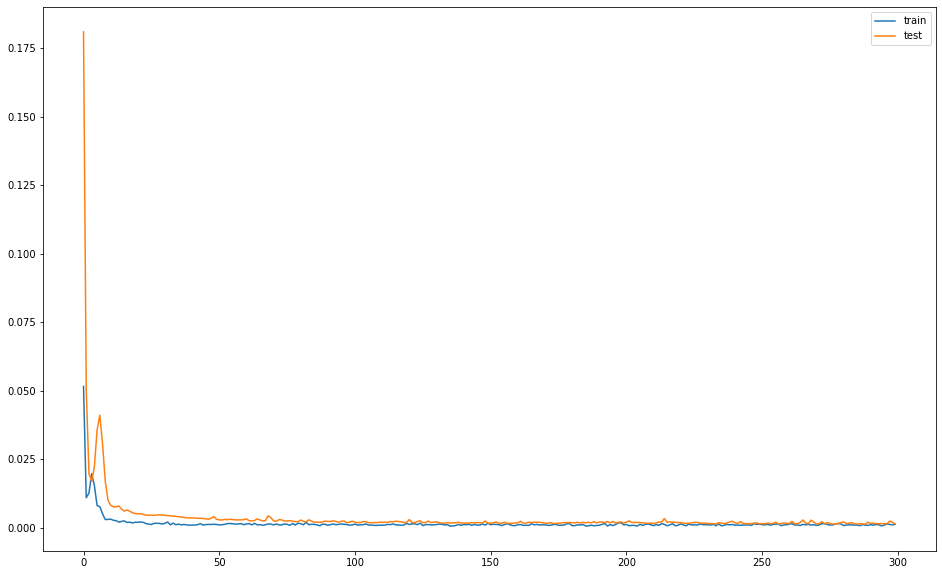

In [938]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [939]:
#
# Berechung der Vorhersagen
#
yhat = model.predict(test_X_r,batch_size=1)
trainyhat = model.predict(train_X_r,batch_size=1)

In [940]:
def invertForecastScaling(x,y):
    # invert scaling for forecast
    inv_yhat = np.concatenate( ( x[:,0:1], y[:,:], x[:, 0:1] ), axis=1 )
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,1]
    return inv_yhat

In [941]:
inv_yhat = invertForecastScaling(test_X,yhat)
print(inv_yhat)

[440.74414 393.86514 353.57    319.10617 337.0909  346.29907 341.5883
 378.2027  383.06036 400.6439  456.03372 493.47638 480.55753 428.58228
 383.0226  344.70828 359.72955 367.55426 361.51688 398.55737 406.9929
 429.91766 492.5335  534.13367 520.21454 460.376   415.31555 373.86502
 391.1378  403.49844 399.69244 441.26865 450.31613 478.07675 543.1603
 590.29803 574.20746 509.7667  460.7569  417.4778 ]


In [942]:
inv_y = invertForecastScaling(test_X,test_y.reshape(-1,1))
print(inv_y)

[466.99997 403.99997 347.      305.      336.      340.      318.
 362.      348.      363.      434.99997 491.      505.      403.99997
 359.      310.      337.      360.      342.      406.      395.99997
 420.      471.99997 548.      559.      462.99997 407.      362.
 404.99997 416.99997 390.99997 418.99997 461.      471.99997 535.
 622.      606.      507.99997 461.      390.     ]


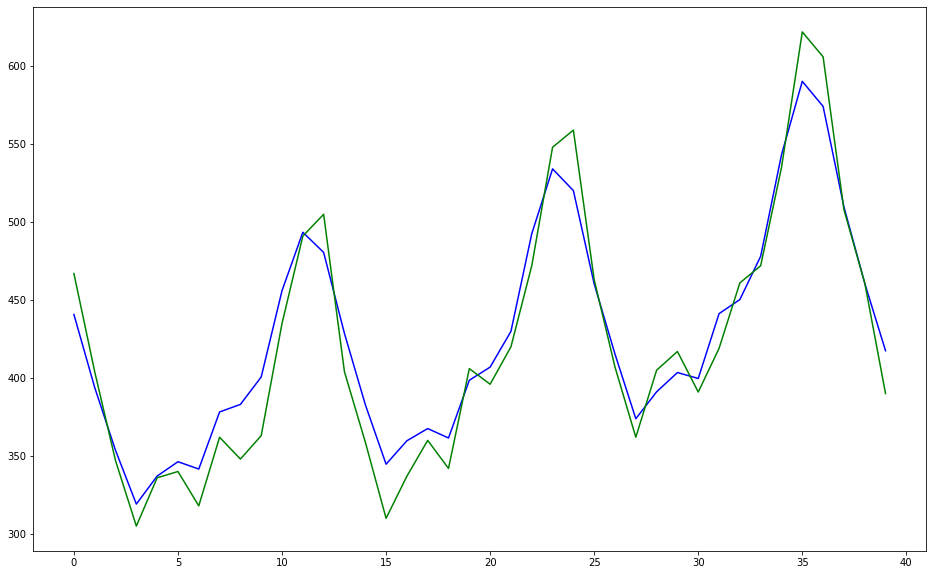

In [943]:
plt.plot(inv_yhat,color='b')
plt.plot(inv_y,color='g')
plt.show()

In [951]:
# calculate RMSE
testScore = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test loss: %.3f RMSE' % testScore)

Test loss: 19.669 RMSE


In [945]:
inv_y_train = invertForecastScaling(train_X,trainyhat.reshape(-1,1))

In [946]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(x_data_raw[:,1])
trainPredictPlot[:] = np.nan
trainPredictPlot[windowSize:len(inv_y_train)+windowSize] = inv_y_train

In [949]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(x_data_raw[:,1])
testPredictPlot[:] = np.nan
testPredictPlot[len(x_data_raw)-len(inv_yhat):len(x_data_raw)] = inv_yhat

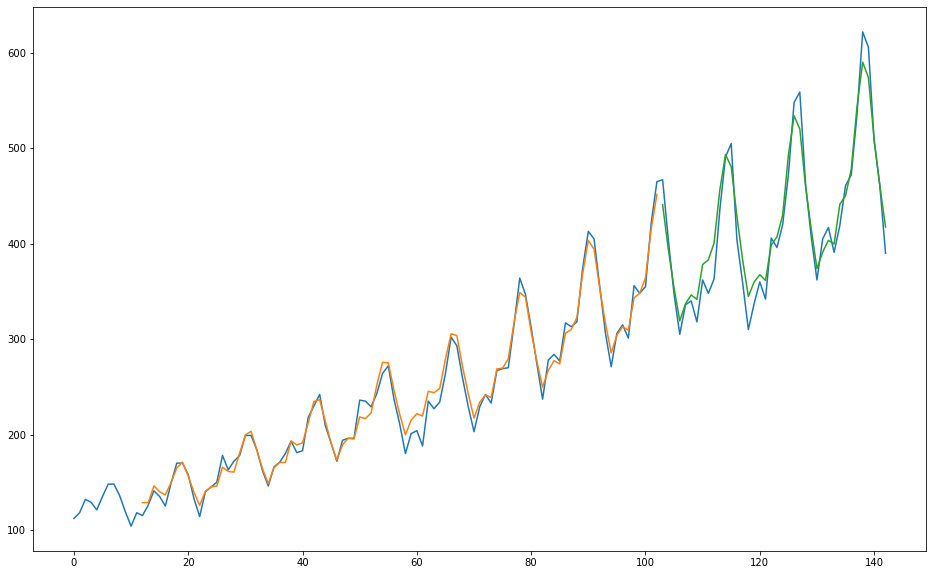

In [950]:
# plot baseline and predictions
plt.plot(x_data_raw[:,1])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Welche Verbesserungsschritte wären sonst noch möglich?